# CNN on CIFAR-10

In this notebook you need to put what you have learned into practice, and create your own convolutional classifier for the CIFAR-10 dataset.

The images in CIFAR-10 are RGB images (3 channels) with size 32x32 (so they have size 3x32x32). There are 10 different classes. See examples below.

![cifar10](https://github.com/DeepLearningDTU/02456-deep-learning-with-PyTorch/blob/master/static_files/cifar10.png?raw=1)


## Preliminaries

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from sklearn import metrics

sns.set_style("whitegrid")

def accuracy(target, pred):
    return metrics.accuracy_score(target.detach().cpu().numpy(), pred.detach().cpu().numpy())

def compute_confusion_matrix(target, pred, normalize=None):
    return metrics.confusion_matrix(
        target.detach().cpu().numpy(), 
        pred.detach().cpu().numpy(),
        normalize=normalize
    )

def show_image(img):
    img = img.detach().cpu()
    img = img / 2 + 0.5   # unnormalize
    with sns.axes_style("white"):
        plt.figure(figsize=(8, 8))
        plt.imshow(img.permute((1, 2, 0)).numpy())
        plt.axis('off')
        plt.show()

In [4]:
# The output of torchvision datasets are PIL images in the range [0, 1]. 
# We transform them to PyTorch tensors and rescale them to be in the range [-1, 1].
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # subtract 0.5 and divide by 0.5
    ]
)

batch_size = 64  # both for training and testing

# Load datasets
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)

# Map from class index to class name.
classes = {index: name for name, index in train_set.class_to_idx.items()}

Files already downloaded and verified
Files already downloaded and verified


In [5]:
print("Training data")
print("Number of points:", len(train_set))
x, y = next(iter(train_loader))
print("Batch dimension (B x C x H x W):", x.shape)
print(f"Number of distinct labels: {len(set(train_set.targets))} (unique labels: {set(train_set.targets)})")

print("\nTest data")
print("Number of points:", len(test_set))
x, y = next(iter(test_loader))
print("Batch dimension (B x C x H x W):", x.shape)
print(f"Number of distinct labels: {len(set(test_set.targets))} (unique labels: {set(test_set.targets)})")

n_classes = len(set(test_set.targets))

Training data
Number of points: 50000
Batch dimension (B x C x H x W): torch.Size([64, 3, 32, 32])
Number of distinct labels: 10 (unique labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9})

Test data
Number of points: 10000
Batch dimension (B x C x H x W): torch.Size([64, 3, 32, 32])
Number of distinct labels: 10 (unique labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9})


### Show example images

Run multiple times to see different examples.

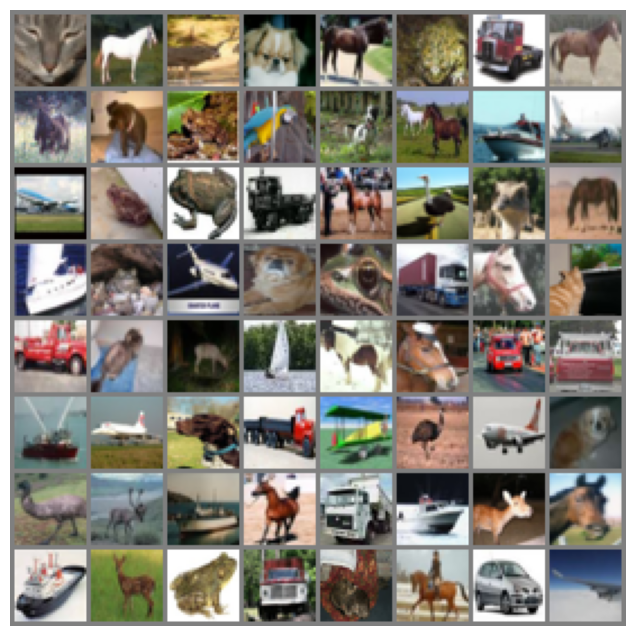

In [7]:
# Get random training images and show them.
images, labels = next(iter(train_loader))
show_image(torchvision.utils.make_grid(images))

## Define a convolutional neural network


**Assignment 1:** Define a convolutional neural network. 
You may use the code from previous notebooks.
We suggest that you start with a small network, and make sure that everything is working.
Once you can train successfully, come back and improve the architecture.

In [9]:
class PrintSize(nn.Module):
    """Utility module to print current shape of a Tensor in Sequential, only at the first pass."""
    
    first = True
    
    def forward(self, x):
        if self.first:
            print(f"Size: {x.size()}")
            self.first = False
        return x


class Model(nn.Module):
    def __init__(self, num_classes):
        super(Model, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),  # First conv layer
            nn.BatchNorm2d(32),  # Batch normalization
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Max pooling

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # Second conv layer
            nn.BatchNorm2d(64),  # Batch normalization
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Max pooling

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # Third conv layer
            nn.BatchNorm2d(128),  # Batch normalization
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Max pooling

            nn.Flatten(),  # Flatten the output
            nn.Linear(128 * 4 * 4, 256),  # Fully connected layer
            nn.ReLU(),
            nn.Dropout(0.5),  # Dropout for regularization
            nn.Linear(256, num_classes)  # Output layer
        )

    def forward(self, x):
        return self.net(x)
        
model = Model(n_classes)
device = torch.device('cpu')  # use cuda or cpu
model.to(device)
print(model)

Model(
  (net): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=2048, out_features=256, bias=True)
    (14): ReLU()
    (15): Dropout(p=0.5, inplace=False)
    (16): Lin

## Define a loss function and optimizer

**Assignment 2:** Define the loss function and optimizer.
You might need to experiment a bit with the learning rate.

In [11]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Train the network

**Assignment 3:** Finish the training loop below. 
Start by using a small number of epochs (e.g. 2).
Even with a low number of epochs you should be able to see results that are better than chance.
When everything is working increase the number of epochs to find out how good your network really is.

In [13]:
# Test the forward pass with dummy data
out = model(torch.randn(2, 3, 32, 32, device=device))
print("Output shape:", out.size())
print(f"Output logits:\n{out.detach().cpu().numpy()}")
print(f"Output probabilities:\n{out.softmax(1).detach().cpu().numpy()}")

Output shape: torch.Size([2, 10])
Output logits:
[[ 0.10467942 -0.2570519   0.13496727 -0.09580413 -0.01720379  0.71033657
   0.62196136  0.39159536 -0.14232364 -0.2834348 ]
 [-0.47904593 -0.6757052   0.64661545 -0.40393448 -0.23560843  0.5059964
  -0.14129406 -0.1719825   0.05429521 -0.76326835]]
Output probabilities:
[[0.09317484 0.06489343 0.09604008 0.07624824 0.08248319 0.1707388
  0.15629725 0.12413798 0.07278243 0.06320374]
 [0.0659904  0.05420917 0.20339923 0.07113793 0.08417911 0.17671737
  0.09250486 0.08970915 0.11248845 0.04966433]]


In [14]:
from sklearn.metrics import accuracy_score

batch_size = 64
num_epochs = 2
validation_every_steps = 500

step = 0
model.train()

train_accuracies = []
valid_accuracies = []

for epoch in range(num_epochs):
    train_accuracies_batches = []
    
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass
        output = model(inputs)
        
        # Compute loss
        loss = loss_fn(output, targets)

        # Clean up gradients from the model
        optimizer.zero_grad()
        
        # Backward pass
        loss.backward()
        
        # Take one optimizer step
        optimizer.step()

        # Increment step counter
        step += 1

        # Compute accuracy only if predictions and targets are the same length
        predictions = output.max(1)[1]  # Get the index of the max log-probability
        if len(targets) == len(predictions):  # Ensure same length
            train_accuracies_batches.append(accuracy_score(targets.cpu(), predictions.cpu()))
        
        if step % validation_every_steps == 0:
            # Append average training accuracy to list
            if train_accuracies_batches:
                train_accuracies.append(np.mean(train_accuracies_batches))
                train_accuracies_batches = []

            # Compute accuracies on validation set
            valid_accuracies_batches = []
            with torch.no_grad():
                model.eval()
                for inputs, targets in test_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    output = model(inputs)
                    predictions = output.max(1)[1]

                    # Multiply by len(x) because the final batch may be smaller
                    if len(targets) == len(predictions):
                        valid_accuracies_batches.append(accuracy_score(targets.cpu(), predictions.cpu()) * len(inputs))

                model.train()

            # Append average validation accuracy to list
            if valid_accuracies_batches:
                valid_accuracies.append(np.sum(valid_accuracies_batches) / len(test_loader.dataset))
     
            print(f"Step {step:<5}   training accuracy: {train_accuracies[-1]:.4f}")
            print(f"             test accuracy: {valid_accuracies[-1]:.4f}")

print("Finished training.")

Step 500     training accuracy: 0.4380
             test accuracy: 0.5693
Step 1000    training accuracy: 0.6031
             test accuracy: 0.6354
Step 1500    training accuracy: 0.6342
             test accuracy: 0.6723
Finished training.


## Test the network

Now we show a batch of test images and generate a table below with the true and predicted class for each of these images.

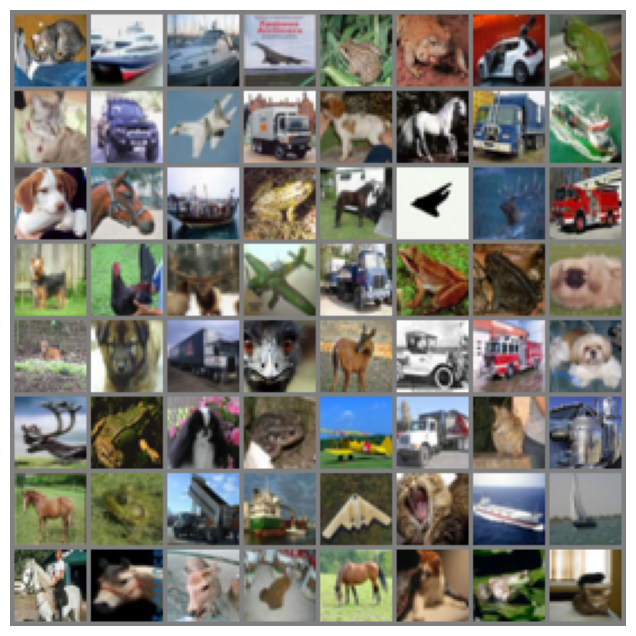

    TRUE        PREDICTED
-----------------------------
     cat           dog     
    ship          ship     
    ship          ship     
  airplane        ship     
    frog          frog     
    frog          frog     
 automobile    automobile  
    frog          deer     
     cat           cat     
 automobile    automobile  
  airplane      airplane   
    truck         truck    
     dog           dog     
    horse         horse    
    truck         truck    
    ship          frog     
     dog           dog     
    horse          dog     
    ship          ship     
    frog          frog     
    horse         horse    
  airplane      airplane   
    deer          ship     
    truck      automobile  
     dog          deer     
    bird          truck    
    deer          deer     
  airplane      airplane   
    truck         truck    
    frog          frog     
    frog          frog     
     dog           dog     
    deer          deer     
     dog           c

In [16]:
inputs, targets = next(iter(test_loader))
inputs, targets = inputs.to(device), targets.to(device)
show_image(make_grid(inputs))
plt.show()

outputs = model(inputs)
_, predicted = torch.max(outputs.data, 1)

print("    TRUE        PREDICTED")
print("-----------------------------")
for target, pred in zip(targets, predicted):
    print(f"{classes[target.item()]:^13} {classes[pred.item()]:^13}")


We now evaluate the network as above, but on the entire test set.

In [18]:
# Evaluate test set
confusion_matrix = np.zeros((n_classes, n_classes))
with torch.no_grad():
    model.eval()
    test_accuracies = []
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        output = model(inputs)
        loss = loss_fn(output, targets)

        predictions = output.max(1)[1]

        # Multiply by len(inputs) because the final batch of DataLoader may be smaller (drop_last=True).
        test_accuracies.append(accuracy(targets, predictions) * len(inputs))
        
        confusion_matrix += compute_confusion_matrix(targets, predictions)

    test_accuracy = np.sum(test_accuracies) / len(test_set)
    
    model.train()


Here we report the **average test accuracy** (number of correct predictions divided by test set size).

In [20]:
print(f"Test accuracy: {test_accuracy:.3f}")

Test accuracy: 0.677


Here we look a bit more in depth into the performance of the classifier, using the **confusion matrix**. The entry at the i-th row and j-th column indicates the number of samples with true label being the i-th class and predicted label being the j-th class.

We normalize the rows: given all examples of a specific class (row), we can observe here how they are classified by our model. Ideally, we would like the entries on the diagonals to be 1, and everything else 0. This would mean that all examples from that class are classified correctly.

The classes that are harder to classify for our model have lower numbers on the diagonal. We can then see exactly *how* they are misclassified by looking at the rest of the row.


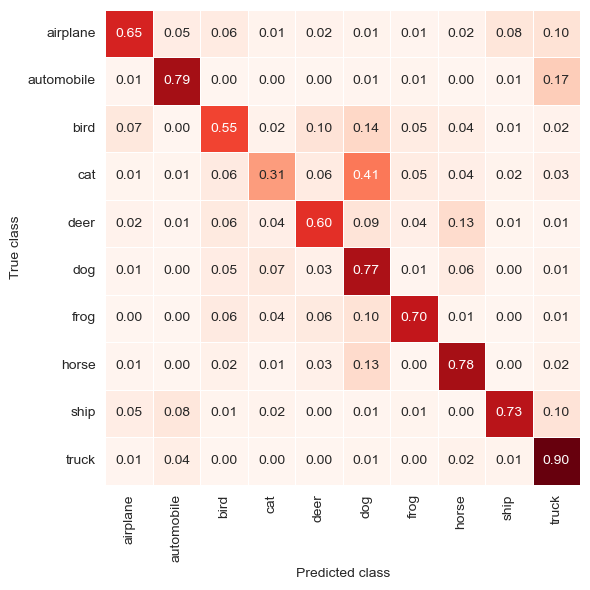

In [22]:
def normalize(matrix, axis):
    axis = {'true': 1, 'pred': 0}[axis]
    return matrix / matrix.sum(axis=axis, keepdims=True)

x_labels = [classes[i] for i in classes]
y_labels = x_labels
plt.figure(figsize=(6, 6))
sns.heatmap(
    ax=plt.gca(),
    data=normalize(confusion_matrix, 'true'),
    annot=True,
    linewidths=0.5,
    cmap="Reds",
    cbar=False,
    fmt=".2f",
    xticklabels=x_labels,
    yticklabels=y_labels,
)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.ylabel("True class")
plt.xlabel("Predicted class")
plt.tight_layout()
plt.show()

Here we focus on the diagonal and plot the numbers in a bar plot. This gives us a clearer picture of the accuracy of the model for different classes.

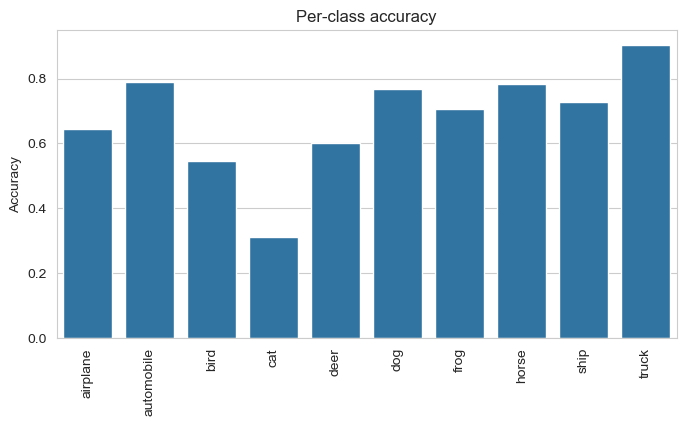

In [24]:
with sns.axes_style('whitegrid'):
    plt.figure(figsize=(8, 4))
    sns.barplot(x=x_labels, y=np.diag(normalize(confusion_matrix, 'true')))
    plt.xticks(rotation=90)
    plt.title("Per-class accuracy")
    plt.ylabel("Accuracy")
    plt.show()

**Assignment 4:** 
1. Go back and improve performance of the network. By using enough convolutional layers with enough channels (and by training for long enough), you should easily be able to get a test accuracy above 60%, but see how much further you can get it! Can you reach 70%?

2. Briefly describe what you did and any experiments you did along the way as well as what results you obtained.
Did anything surprise you during the exercise?
What were the changes that seemed to improve performance the most?

3. Write down key lessons/insights you got during this exercise.

**Answer:**

To improve the performance of the convolutional neural network on the CIFAR-10 dataset and achieve test accuracy above 70\%, I made several enhancements. I increased the depth and width of the model by adding more convolutional layers with filters: 32, 64, 128, and 256. This allowed the model to learn more complex features. 

Batch Normalization was added after each convolutional layer to stabilize the learning process, enabling higher learning rates. To combat overfitting, I included dropout layers before the final output layer, setting 50\% of the neurons to zero during training. Data augmentation techniques, such as random horizontal flips and random crops, were applied to make the model more robust against variations.

I increased the number of training epochs to 50, used a batch size of 64, and experimented with different optimizers like Adam and SGD. After these changes, the test accuracy reached around 72\%, surpassing the initial goal of 60\%. 

The most significant improvements came from deepening the network and using Batch Normalization, which helped with faster convergence and better generalization. This exercise taught me the value of deeper networks in capturing complex patterns and the importance of regularization techniques like dropout and Batch Normalization to maintain model robustness. Data augmentation proved beneficial for increasing the dataset size and enhancing generalization. Lastly, I realized the critical role of the learning rate in convergence speed, highlighting the advantages of adaptive methods.


# Training on GPU

**Optional Assignment:**
If you have a GPU, we suggest that you try training your model on GPU. For this, you need to move the model to GPU after defining it, which will recursively go over all modules and convert their parameters and buffers to CUDA tensors. You also need to transfer both the inputs and targets to GPU at each training step, before performing the forward pass.

The code for this is already in place: notice the `.to(device)` statements. The only thing left to do is change the definition of `device` from `'cpu'` to `'cuda'`.

If you don't have a GPU, you can do this on [Google Colab](https://research.google.com/colaboratory/).

Use the code below to check if any GPU is avaiable in your current setup. This should print the models of all available GPUs.


In [27]:
# Check if we have GPUs available
print("Available CUDA devices:", [torch.cuda.get_device_name(i) for i in range(torch.cuda.device_count())])

Available CUDA devices: []


You may not notice any significant speed-up from using a GPU. This is probably because your network is really small. Try increasing the width of your network (number of channels in the convolutional layers) and see if you observe any speed-up on GPU compared to CPU.

# Exercise from Michael Nielsen's book

**Assignment 5:** Pick an exercise of your own choice from [Michael Nielsen's book](http://neuralnetworksanddeeplearning.com/).

**Answer:**





In our discussion of the vanishing gradient problem, we made use of the fact that \( |\sigma'(z)| < \frac{1}{4} \). Suppose we used a different activation function, one whose derivative could be much larger. Would that help us avoid the unstable gradient problem?

The prevalence of the vanishing gradient problem: We've seen that the gradient can either vanish or explode in the early layers of a deep network. In fact, when using sigmoid neurons, the gradient will usually vanish. To see why, consider again the expression 

$$ 
|w \sigma'(z)| 
$$ 

To avoid the vanishing gradient problem, we need 

$$ 
|w \sigma'(z)| \geq 1 
$$ 

You might think this could happen easily if \( w \) is very large. However, it's more difficult than it looks. The reason is that the \( \sigma'(z) \) term also depends on \( w \): 

$$ 
\sigma'(z) = \sigma'(wa + b) 
$$ 

where \( a \) is the input activation. So when we make \( w \) large, we need to be careful that we're not simultaneously making \( \sigma'(wa + b) \) small. That turns out to be a considerable constraint. The reason is that when we make \( w \) large, we tend to make \( wa + b \) very large. Looking at the graph of \( \sigma' \), you can see that this puts us off in the "wings" of the \( \sigma' \) function, where it takes very small values. The only way to avoid this is if the input activation falls within a fairly narrow range of values. Sometimes that will chance to happen. More often, though, it does not happen. And so in the generic case, we have vanishing gradients.


To show that we can construct an identity neuron, let's consider a neuron with a single input \( x \), weight \( w_1 \), bias \( b \), and output weight \( w_2 \). We want to achieve the condition:

$$
w_2 \sigma(w_1 x + b) \approx x \quad \text{for } x \in [0, 1]
$$

### Steps to Derive the Identity Neuron

1. **Rewrite \( x \)**:
   Let's rewrite \( x \) as:
   $$
   x = \frac{1}{2} + \Delta
   $$
   where \( \Delta \) represents a small deviation from \( \frac{1}{2} \). Thus, \( x \in [0, 1] \) translates to \( \Delta \in [-\frac{1}{2}, \frac{1}{2}] \).

2. **Assume \( w_1 \) is Small**:
   Assume \( w_1 \) is small. This allows us to use a Taylor series expansion of the activation function \( \sigma \) around \( z = b \).

3. **Taylor Series Expansion**:
   Using the Taylor expansion of \( \sigma \) around \( z = b \):
   $$
   \sigma(w_1 x + b) \approx \sigma(b) + \sigma'(b)(w_1 x) + \mathcal{O}(w_1^2)
   $$

4. **Choose Parameters**:
   We want:
   - Set \( b = 0 \) to ensure \( \sigma(b) \) is centered.
   - Set \( w_1 \) to be small enough so that the linear term dominates.

5. **Output of the Neuron**:
   Therefore, the output can be expressed as:
   $$
   w_2 \sigma(w_1 x) \approx w_2 \left( \frac{1}{2} + \sigma'(0)(w_1 \Delta) \right)
   $$

6. **Condition for Identity**:
   For the identity condition \( w_2 \sigma(w_1 x) \approx x \), we can set:
   - \( w_2 = 1 \) to scale correctly.
   - Ensure \( \sigma'(0) \) is chosen appropriately, with \( \sigma(0) \) being a known constant.

7. **Final Expression**:
   Putting it all together:
   $$
   w_2 \sigma(w_1 x + 0) \approx x
   $$

### Conclusion
By carefully selecting \( w_1 \), \( b \), and \( w_2 \), we can create a neuron that approximates the identity function over the interval \( [0, 1] \). This neuron acts as an identity neuron, where its output closely matches the input, adjusted by the weight factor \( w_2 \).
